In [7]:
cd ~/Umila/numila

/Users/fred/Umila/numila


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [9]:
from collections import Counter
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import plotting

from numila import Numila
import utils

## Setup

We first train the model on two corpora generated by PCFGS. The two PCFGs are identical except for one `DET` and one `NOUN`. The first has "that" and "table", while the second has "my" and "bunny". Importantly, _the model never sees "my table" or "that bunny"_. Thus, if the model is just tracking statistics between individual words (or chunks), then we expect "that table" to have a chunkability of 0 because the model has never seen this chunk. If the model is able to generalize, however, it will (1) capture the similarity of "table" to the other nouns, (2) notice that these other nouns have occurred with "table", and (3) use this information to assign a non-zero chunkability to "that table".

In [18]:
# Train the model.
import pcfg
toy_pcfg = '''
S    -> NP VP [1.0]
VP   -> V NP [0.5]
VP   -> V [0.5]
NP   -> Det N [0.7]
NP   -> Name [0.3]
V    -> 'saw' [0.5]
V    -> 'ate' [0.5]
N    -> 'boy' [0.5]
N    -> '{NOUN}' [0.50]
Name -> 'Jack' [0.5]
Name -> 'Bob' [0.5]
Det  -> 'the' [0.5]
Det  -> '{DET}' [0.5]
'''

that_table_pcfg = toy_pcfg.format(DET='that', NOUN='table')
my_bunny_pcfg = toy_pcfg.format(DET='my', NOUN='bunny')
corpus = (list(pcfg.random_sentences(that_table_pcfg, 100))
          + list(pcfg.random_sentences(my_bunny_pcfg, 100)))

# Mix sentences from each corpus. This is essential for the dynamic
# generalization algorithm to work.
np.random.shuffle(corpus)

# Check how many times each critical pair occured.
bigrams = Counter(itertools.chain(*(list(utils.neighbors(utt.split(' '))) for utt in corpus)))
for det in 'that', 'my':
    for noun in 'table', 'bunny':
        print(det, noun, ':', bigrams[(det, noun)])
        
# Train the models.
models = {'none': Numila(),
          'dynamic': Numila(DYNAMIC=0.5),
          'general': Numila(GENERALIZE=0.5)
         }
for model in models.values():
    model.fit(corpus)

[numila]	Trained on 200 utterances in 0.6375000476837158 seconds
[numila]	Trained on 200 utterances in 22.577763080596924 seconds
[numila]	Trained on 200 utterances in 0.2671089172363281 seconds


that table : 23
that bunny : 0
my table : 0
my bunny : 24


In [23]:
# m = models['dynamic']
# that, my, table, bunny, Jack, saw = map(m.graph.get, 
#   ['that', 'my', 'table', 'bunny', 'Jack', 'saw'])

# print(that.edge_weight(bunny, 'ftp', dynamic=0.5))
# print(my.edge_weight(table, 'ftp', dynamic=0.5))


model = models['dynamic']
for det in 'my', 'that':
    det = model.graph[det]
    for noun in 'bunny', 'table':
        noun = model.graph[noun]

        print()
        print(det, noun, 'ftp')
        print(det.edge_weight(noun, 'ftp'))
        print(det.edge_weight(noun, 'ftp', dynamic=1))
        print(det.edge_weight(noun, 'ftp', generalize=1))

        print()
        print(det, noun, 'btp')
        print(noun.edge_weight(det, 'btp'))
        print(noun.edge_weight(det, 'btp', dynamic=1))
        print(noun.edge_weight(det, 'btp', generalize=1))


my bunny ftp
0.541106272792
0.336444455026
0.391540822481

my bunny btp
0.646161301904
0.330811453248
0.497702044263

my table ftp
0.0410338923534
0.26688537724
0.313521302296

my table btp
0.0
0.231020626958
0.36550069866

that bunny ftp
0.0113554288681
0.206903955637
0.301088519881

that bunny btp
0.00215387100635
0.383058802846
0.349881350269

that table ftp
0.589988586841
0.317129297689
0.406749790268

that table btp
0.703449332318
0.47850047688
0.493880114363


## Results

Generalization increases chunkiness for the unseen DET-NOUN pairs without having a large effect on other pairs. 

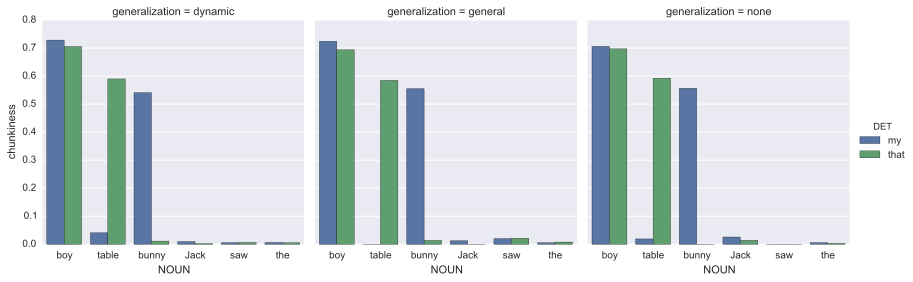

In [20]:
# Test chunkabilities.

data = [(name, det, noun,
         model.chunkiness(model.graph[det], model.graph[noun]))
        for name, model in models.items()
        for det in ['my', 'that']
        for noun in ['boy', 'table', 'bunny', 'Jack', 'saw', 'the']]

df = pd.DataFrame(data, columns=['generalization', 'DET', 'NOUN', 'chunkiness'])
sns.factorplot('NOUN', 'chunkiness', col='generalization', hue='DET', data=df, kind='bar')
sns.plt.savefig('figs/generalization.pdf')

As expected, `[my table]` and `[that bunny]` have 0 chunkability when generalization is 0. This is because these words never occur adjacently in the training data. When we apply generalization, however, the model assigns some chunkiness to these pairs that it has never seen.

Additionally, although there is some over-generalization, this is due mostly to noise with the exception of Jack. In this case, Jack, bunny, and table all end a noun phrase, and are thus followed by verbs. This results in similar FTP edges. However, preceding words will not be common, thus BTP edges will be very different. Because a multiplicative similarity rule is used, the dissimilarity in BTP mostly outweights the similarity in FTP. 

# Experiment 2: Single occurrence

In [14]:
     
corpus = list(pcfg.random_sentences(that_table_pcfg, 100))
# np.random.shuffle(corpus)



# Train the models.
models = {'none': Numila(),
          'dynamic': Numila(DYNAMIC=0.5),
          'general': Numila(GENERALIZE=0.5)
         }
for model in models.values():
    model.fit(corpus)

[numila]	Trained on 100 utterances in 0.31618595123291016 seconds
[numila]	Trained on 100 utterances in 5.9893388748168945 seconds
[numila]	Trained on 100 utterances in 0.13868284225463867 seconds


In [17]:
for name, model in models.items():
    model.parse('Jack saw the bunny'.split(' '))
    print(name, model.chunkiness(model.graph['that'], model.graph['bunny']))

dynamic 0.00810116943851
general 0.0212104848078
none 0.0
